In [68]:
import ee
import datetime
import matplotlib.pyplot as plt
import pandas as pd

ee.Initialize()

In [55]:
# ---------- Utility Function ---------- #

def normalize_index(index, geometry, scale):
    band_name = index.bandNames().get(0).getInfo()
    min_max = index.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e9
    )
    min_val = ee.Number(min_max.get(f"{band_name}_min"))
    max_val = ee.Number(min_max.get(f"{band_name}_max"))
    return index.subtract(min_val).divide(max_val.subtract(min_val)).rename('Normalized')

In [56]:
# ---------- Dataset Configurations ---------- #

datasets = {
    'Sentinel-2': {
        'collection': 'COPERNICUS/S2_SR_HARMONIZED',
        'bands': { 'NIR': 'B8', 'RED': 'B4', 'BLUE': 'B2', 'GREEN': 'B3', 'SWIR1': 'B11' },
        'scale': 100,
        'mask': lambda img: img.updateMask(
            img.select('QA60').bitwiseAnd(1 << 10).eq(0)
            .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))
        )
    },
    'Landsat 9': {
        'collection': 'LANDSAT/LC09/C02/T1_L2',
        'bands': { 'NIR': 'SR_B5', 'RED': 'SR_B4', 'BLUE': 'SR_B2', 'GREEN': 'SR_B3', 'SWIR1': 'SR_B6' },
        'scale': 100,
        'mask': lambda img: img.updateMask(img.select('QA_PIXEL').bitwiseAnd(1 << 5).eq(0))
    },
    'MODIS': {
        'collection': 'MODIS/006/MOD09GA',
        'bands': { 'NIR': 'sur_refl_b02', 'RED': 'sur_refl_b01', 'BLUE': 'sur_refl_b03', 'GREEN': 'sur_refl_b04', 'SWIR1': 'sur_refl_b06' },
        'scale': 500,
        'mask': lambda img: img.updateMask(img.select('QC_500m').bitwiseAnd(1 << 0).eq(0))
    }
}

In [57]:
# ---------- Vegetation Index Computation ---------- #

def compute_indices(image, bands):
    NIR = image.select(bands['NIR'])
    RED = image.select(bands['RED'])
    BLUE = image.select(bands['BLUE'])
    GREEN = image.select(bands['GREEN'])
    SWIR1 = image.select(bands['SWIR1'])

    ndvi = NIR.subtract(RED).divide(NIR.add(RED)).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': NIR, 'RED': RED, 'BLUE': BLUE}
    ).rename('EVI')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': NIR, 'RED': RED}
    ).rename('SAVI')
    dvi = NIR.subtract(RED).rename('DVI')
    ndwi = NIR.subtract(SWIR1).divide(NIR.add(SWIR1)).rename('NDWI')
    gndvi = NIR.subtract(GREEN).divide(NIR.add(GREEN)).rename('GNDVI')
    bsi = image.expression(
        '((SWIR1 + RED) - (NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))',
        {'SWIR1': SWIR1, 'RED': RED, 'NIR': NIR, 'BLUE': BLUE}
    ).rename('BSI')

    indices = [ndvi, evi, savi, dvi, ndwi, gndvi, bsi]
    normalized = [idx.unitScale(-1, 1).clamp(0, 1) for idx in indices]

    return image.addBands(normalized)

In [61]:
# ---------- Chart Creation Function ---------- #

def create_chart(start_date, end_date, lon, lat, dataset_key):
    ds = datasets[dataset_key]
    point = ee.Geometry.Point([lon, lat])
    collection = ee.ImageCollection(ds['collection']) \
        .filterBounds(point) \
        .filterDate(start_date, end_date) \
        .map(ds['mask']) \
        .map(lambda img: compute_indices(img, ds['bands']))

    def extract_values(img):
        date = img.date().format('YYYY-MM-dd')
        stats = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=ds['scale'],
            maxPixels=1e9
        )
        return ee.Feature(None, stats).set('date', date)

    features = collection.map(extract_values).getInfo()['features']

In [1]:
# ---------- Plotting ---------- #
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([f['properties'] for f in features])
df['date'] = pd.to_datetime([f['properties']['date'] for f in features])
df = df.sort_values('date')

plt.figure(figsize=(12, 6))
for idx in ['NDVI', 'EVI', 'SAVI', 'DVI', 'NDWI', 'GNDVI', 'BSI']:
    if idx in df.columns:
        plt.plot(df['date'], df[idx], label=idx)

plt.title(f'Vegetation Indices Over Time ({dataset_key})')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'features' is not defined

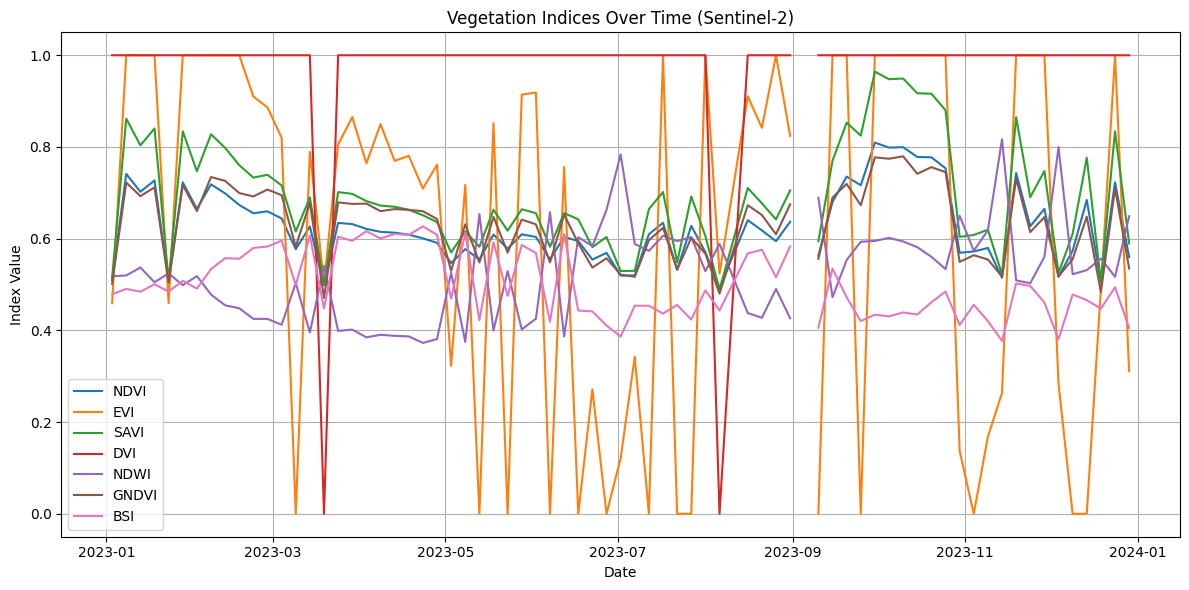

In [2]:
import ee
import datetime
import matplotlib.pyplot as plt

ee.Initialize()

# ---------- Utility Function ---------- #

def normalize_index(index, geometry, scale):
    band_name = index.bandNames().get(0).getInfo()
    min_max = index.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e9
    )
    min_val = ee.Number(min_max.get(f"{band_name}_min"))
    max_val = ee.Number(min_max.get(f"{band_name}_max"))
    return index.subtract(min_val).divide(max_val.subtract(min_val)).rename('Normalized')

# ---------- Dataset Configurations ---------- #

datasets = {
    'Sentinel-2': {
        'collection': 'COPERNICUS/S2_SR_HARMONIZED',
        'bands': { 'NIR': 'B8', 'RED': 'B4', 'BLUE': 'B2', 'GREEN': 'B3', 'SWIR1': 'B11' },
        'scale': 100,
        'mask': lambda img: img.updateMask(
            img.select('QA60').bitwiseAnd(1 << 10).eq(0)
            .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))
        )
    },
    'Landsat 9': {
        'collection': 'LANDSAT/LC09/C02/T1_L2',
        'bands': { 'NIR': 'SR_B5', 'RED': 'SR_B4', 'BLUE': 'SR_B2', 'GREEN': 'SR_B3', 'SWIR1': 'SR_B6' },
        'scale': 100,
        'mask': lambda img: img.updateMask(img.select('QA_PIXEL').bitwiseAnd(1 << 5).eq(0))
    },
    'MODIS': {
        'collection': 'MODIS/006/MOD09GA',
        'bands': { 'NIR': 'sur_refl_b02', 'RED': 'sur_refl_b01', 'BLUE': 'sur_refl_b03', 'GREEN': 'sur_refl_b04', 'SWIR1': 'sur_refl_b06' },
        'scale': 500,
        'mask': lambda img: img.updateMask(img.select('QC_500m').bitwiseAnd(1 << 0).eq(0))
    }
}

# ---------- Vegetation Index Computation ---------- #

def compute_indices(image, bands):
    NIR = image.select(bands['NIR'])
    RED = image.select(bands['RED'])
    BLUE = image.select(bands['BLUE'])
    GREEN = image.select(bands['GREEN'])
    SWIR1 = image.select(bands['SWIR1'])

    ndvi = NIR.subtract(RED).divide(NIR.add(RED)).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': NIR, 'RED': RED, 'BLUE': BLUE}
    ).rename('EVI')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': NIR, 'RED': RED}
    ).rename('SAVI')
    dvi = NIR.subtract(RED).rename('DVI')
    ndwi = NIR.subtract(SWIR1).divide(NIR.add(SWIR1)).rename('NDWI')
    gndvi = NIR.subtract(GREEN).divide(NIR.add(GREEN)).rename('GNDVI')
    bsi = image.expression(
        '((SWIR1 + RED) - (NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))',
        {'SWIR1': SWIR1, 'RED': RED, 'NIR': NIR, 'BLUE': BLUE}
    ).rename('BSI')

    indices = [ndvi, evi, savi, dvi, ndwi, gndvi, bsi]
    normalized = [idx.unitScale(-1, 1).clamp(0, 1) for idx in indices]

    return image.addBands(normalized)

# ---------- Chart Creation Function ---------- #

def create_chart(start_date, end_date, lon, lat, dataset_key):
    ds = datasets[dataset_key]
    point = ee.Geometry.Point([lon, lat])
    collection = ee.ImageCollection(ds['collection']) \
        .filterBounds(point) \
        .filterDate(start_date, end_date) \
        .map(ds['mask']) \
        .map(lambda img: compute_indices(img, ds['bands']))

    def extract_values(img):
        date = img.date().format('YYYY-MM-dd')
        stats = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=ds['scale'],
            maxPixels=1e9
        )
        return ee.Feature(None, stats).set('date', date)

    features = collection.map(extract_values).getInfo()['features']

    # ---------- Plotting ---------- #
    import pandas as pd
    df = pd.DataFrame([f['properties'] for f in features])
    df['date'] = pd.to_datetime([f['properties']['date'] for f in features])
    df = df.sort_values('date')

    plt.figure(figsize=(12, 6))
    for idx in ['NDVI', 'EVI', 'SAVI', 'DVI', 'NDWI', 'GNDVI', 'BSI']:
        if idx in df.columns:
            plt.plot(df['date'], df[idx], label=idx)

    plt.title(f'Vegetation Indices Over Time ({dataset_key})')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------- Example Usage ---------- #

create_chart('2023-01-01', '2023-12-31', lon=79.1, lat=12.9, dataset_key='Sentinel-2')
